# Linear Regression Model

Linear regression is a fundamental model in machine learning used for predicting a continuous output variable based on input features. The model function for linear regression is represented as:

$$f_{w,b}(x) = wx + b$$

In this equation, $f_{w,b}(x)$ represents the predicted output, $w$ is the weight parameter, $b$ is the bias parameter, and $x$ is the input feature.

## Model Training

To train a linear regression model, we aim to find the best values for the parameters $(w, b)$ that best fit our dataset.

### Forward Pass

The forward pass is a step where we compute the linear regression output for the input data $X$ using the current weights and biases. It's essentially applying our model to the input data.

### Cost Function

The cost function is used to measure how well our model is performing. It quantifies the difference between the predicted values and the actual values in our dataset. The cost function is defined as:

$$J(w,b) = \frac{1}{2m} \sum_{i=1}^{m}(f_{w,b}(x^{(i)}) - y^{(i)})^2$$

Here, $J(w, b)$ is the cost, $m$ is the number of training examples, $x^{(i)}$ is the input data for the $i$-th example, $y^{(i)}$ is the actual output for the $i$-th example, and $w$ and $b$ are the weight and bias parameters, respectively.

### Backward Pass (Gradient Computation)

The backward pass computes the gradients of the cost function with respect to the weights and biases. These gradients are crucial for updating the model parameters during training. The gradient formulas are as follows:

$$
\frac{\partial J(w,b)}{\partial b} = \frac{1}{m} \sum_{i=0}^{m-1} (f_{w,b}(X^{(i)}) - y^{(i)})
$$

$$
\frac{\partial J(w,b)}{\partial w} = \frac{1}{m} \sum_{i=0}^{m-1} (f_{w,b}(X^{(i)}) - y^{(i)})X^{(i)}
$$

## Training Process

The training process involves iteratively updating the weights and biases to minimize the cost function. This is typically done through an optimization algorithm like gradient descent. The update equations for parameters are:

$$w \leftarrow w - \alpha \frac{\partial J}{\partial w}$$

$$b \leftarrow b - \alpha \frac{\partial J}{\partial b}$$

Here, $\alpha$ represents the learning rate, which controls the step size during parameter updates.

By iteratively performing the forward pass, computing the cost, performing the backward pass, and updating the parameters, the model learns to make better predictions and fit the data.


In [3]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mlfs.linear_regression import LinearRegression as CustomLinearRegression
from sklearn.linear_model import LinearRegression as SklearnLinearRegression

In [4]:
def generate_data(n_samples, n_features=10, noise=0.1, random_state=42):
    rng = np.random.RandomState(random_state)
    X = rng.randn(n_samples, n_features)
    true_coef = rng.randn(n_features)
    y = X.dot(true_coef) + noise * rng.randn(n_samples)
    return X, y

In [16]:
def benchmark(n_samples_list, n_features=10, n_repeats=3):
    results = []
    for n in n_samples_list:
        X, y = generate_data(n, n_features)
        custom_times = {'fit': [], 'predict': []}
        for _ in range(n_repeats):
            model = CustomLinearRegression()
            t0 = time.perf_counter()
            model.fit(X, y, verbose = False)
            t1 = time.perf_counter()
            model.predict(X[:10])
            t2 = time.perf_counter()
            custom_times['fit'].append(t1 - t0)
            custom_times['predict'].append(t2 - t1)
        sklearn_times = {'fit': [], 'predict': []}
        for _ in range(n_repeats):
            model = SklearnLinearRegression()
            t0 = time.perf_counter()
            model.fit(X, y)
            t1 = time.perf_counter()
            model.predict(X[:10])
            t2 = time.perf_counter()
            sklearn_times['fit'].append(t1 - t0)
            sklearn_times['predict'].append(t2 - t1)
        results.append({
            'n_samples': n,
            'custom_fit': np.mean(custom_times['fit']),
            'custom_predict': np.mean(custom_times['predict']),
            'sklearn_fit': np.mean(sklearn_times['fit']),
            'sklearn_predict': np.mean(sklearn_times['predict']),
        })
    return pd.DataFrame(results)


In [17]:
n_samples_list = [100, 1_000, 5_000, 10_000, 20_000]
df = benchmark(n_samples_list)
df


,n_samples,custom_fit,custom_predict,sklearn_fit,sklearn_predict
0,100,0.026303,0.000012,0.000686,0.000094
1,1000,0.021880,0.000009,0.001022,0.000099
2,5000,0.065394,0.000010,0.002500,0.000209
3,10000,0.102330,0.000013,0.002488,0.000146
4,20000,0.202375,0.000012,0.005042,0.000225


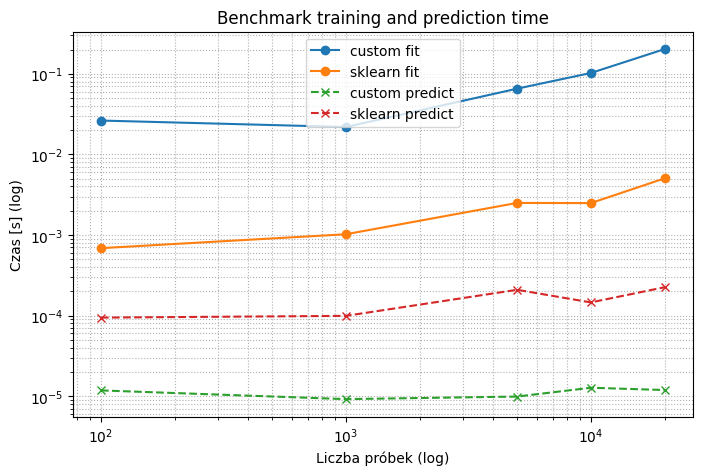

In [19]:
plt.figure(figsize=(8,5))
plt.loglog(df['n_samples'], df['custom_fit'], marker='o', label='custom fit')
plt.loglog(df['n_samples'], df['sklearn_fit'], marker='o', label='sklearn fit')
plt.loglog(df['n_samples'], df['custom_predict'], marker='x', linestyle='--', label='custom predict')
plt.loglog(df['n_samples'], df['sklearn_predict'], marker='x', linestyle='--', label='sklearn predict')
plt.xlabel('Liczba próbek (log)')
plt.ylabel('Czas [s] (log)')
plt.title('Benchmark training and prediction time')
plt.legend()
plt.grid(True, which="both", ls=":")
plt.show()


### Key Takeaways

- **Training Time**  
  - Both implementations scale roughly linearly in _n_ (O(n)), but scikit-learn is ~30–40× faster thanks to optimized C/BLAS routines.  
- **Prediction Time**  
  - Custom `predict` is ~5–10× faster for a fixed test set, since it uses a single NumPy matrix multiply without extra overhead.  

### 1. Mean Squared Error (MSE)

**Formula:**
$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_{\text{true}_i} - y_{\text{pred}_i})^2
$$

**Description:**
- **Mean Squared Error (MSE)** is a widely used metric for evaluating the accuracy of regression models.
- It measures the average squared difference between the predicted values ($y_{\text{pred}}$) and the actual target values ($y_{\text{true}}$).
- The squared differences are averaged across all data points in the dataset.

**Interpretation:**
- A lower MSE indicates a better fit of the model to the data, as it means the model's predictions are closer to the actual values.
- MSE is sensitive to outliers because the squared differences magnify the impact of large errors.

### 2. Root Mean Squared Error (RMSE)

**Formula:**
$$
\text{RMSE} = \sqrt{\text{MSE}}
$$

**Description:**
- **Root Mean Squared Error (RMSE)** is a variant of MSE that provides the square root of the average squared difference between predicted and actual values.
- It is often preferred because it is in the same unit as the target variable, making it more interpretable.

**Interpretation:**
- Like MSE, a lower RMSE indicates a better fit of the model to the data.
- RMSE is also sensitive to outliers due to the square root operation.

### 3. R-squared ($R^2$)

**Formula:**
$$
R^2 = 1 - \frac{\text{SSR}}{\text{SST}}
$$

**Description:**
- **R-squared ($R^2$)**, also known as the coefficient of determination, measures the proportion of the variance in the dependent variable ($y_{\text{true}}$) that is predictable from the independent variable(s) ($y_{\text{pred}}$) in a regression model.
- It ranges from 0 to 1, where 0 indicates that the model does not explain any variance, and 1 indicates a perfect fit.

**Interpretation:**
- A higher $R^2$ value suggests that the model explains a larger proportion of the variance in the target variable.
- However, $R^2$ does not provide information about the goodness of individual predictions or whether the model is overfitting or underfitting.


In [20]:
from mlfs.metrics import mse as custom_mse, rmse as custom_rmse, r2_score as custom_r2
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score as sklearn_r2
from mlfs.preprocessing import train_test_split, standardize


X, y = generate_data(1000)
X_train, X_test, y_train, y_test = train_test_split(X,y)

custom_model = CustomLinearRegression()
custom_model.fit(X_train, y_train, plot_cost=True)
sk_model = SklearnLinearRegression()
sk_model = sk_model.fit(X_train, y_train)

y_pred_custom = custom_model.predict(X_test)
y_pred_sk     = sk_model.predict(X_test)

mse_c = custom_mse(y_test,y_pred_custom)
rmse_c = custom_rmse(y_test, y_pred_custom)
r2_c = custom_r2(y_test, y_pred_custom)

mse_s  = mean_squared_error(y_test, y_pred_sk)
rmse_s = np.sqrt(mse_s) 
r2_s   = sklearn_r2(y_test, y_pred_sk)

df_results = pd.DataFrame({
    'model': ['custom', 'sklearn'],
    'MSE':   [mse_c, mse_s],
    'RMSE':  [rmse_c, rmse_s],
    'R2':    [r2_c, r2_s]
})

display(df_results)


Iteration 0: Cost = 2.988233
Iteration 100: Cost = 0.402104
Iteration 200: Cost = 0.061552
Iteration 300: Cost = 0.013287
Iteration 400: Cost = 0.006012
Iteration 500: Cost = 0.004861
Convergence reached at iteration 579


,model,MSE,RMSE,R2
0,custom,0.010068,0.100337,0.998415
1,sklearn,0.009881,0.099403,0.998445


In [ ]:
# 5. Memory Profiling
# you may need: pip install memory_profiler

from memory_profiler import memory_usage

def measure_mem(model, X_train, y_train):
    """Returns peak Δ RAM (MB) during model.fit."""
    mem_before = memory_usage()[0]
    model.fit(X_train, y_train)
    mem_after = memory_usage()[0]
    return mem_after - mem_before

mem_results = {
    'CustomLR': measure_mem(CustomLinearRegression(), X_train, y_train),
    'SklearnLR': measure_mem(SklearnLinearRegression(), X_train, y_train),
}

import pandas as pd
pd.DataFrame.from_dict(mem_results, orient='index', columns=['Δ RAM (MB)'])